In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML

In [32]:
# allow output to span multiple output lines in the console
pd.set_option('display.max_columns', 600)
pd.options.display.width = 100
pd.options.display.max_colwidth = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

In [33]:
def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """

    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

### Read the data

Download the 2 heartbeat data files from
https://www.kaggle.com/shayanfazeli/heartbeat

You can also get the files from my Google Drive:

[ptbdb_abnormal.csv](https://drive.google.com/file/d/1Kuvc_WmjLhz1xaSvL-bu94i8dEU4JMws/view?usp=sharing)

[ptbdb_normal.csv](https://drive.google.com/file/d/1L0qVW-xTGcaEgS4NdY6ZhzEEWTqMTQCH/view?usp=sharing)

In [34]:
data_dir = "C:/Users/Glenn/Google Drive/CSUMB/Fall21/AML/lectures-labs/9neural-nets/3cnn/ekg-data/"
df_normal = pd.read_csv(data_dir+"ptbdb_normal.csv",   header=None)
df_abnormal = pd.read_csv(data_dir+"ptbdb_abnormal.csv", header=None)

In [35]:
df_normal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4046 entries, 0 to 4045
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 5.8 MB


In [36]:
df_normal.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,0.106564,0.106969,0.115883,0.122366,0.122366,0.119530,0.115883,0.122366,0.126013,0.133712,0.134927,0.142626,0.151135,0.158428,0.163695,0.173825,0.188817,0.207861,0.230956,0.258509,0.294571,0.325770,0.362642,0.398298,0.429498,0.449352,0.450972,0.418963,0.372771,0.310373,0.250000,0.204214,0.168963,0.147488,0.130470,0.124392,0.117504,0.116694,0.115883,0.118720,0.115478,0.113857,0.119530,0.116694,0.122771,0.120746,0.116694,0.122771,0.126418,0.131686,0.141815,0.139384,0.145057,0.143436,0.141005,0.140600,0.138169,0.136953,0.132091,0.128444,0.128444,0.128039,0.125203,0.122366,0.117099,0.112642,0.113047,0.127634,0.165316,0.179498,0.161264,0.176661,0.182739,0.174635,0.151540,0.147893,0.134927,0.122771,0.106969,0.098055,0.094408,0.089141,0.089141,0.088736,0.090762,0.085900,0.085900,0.089141,0.084279,0.057942,0.000000,0.116288,0.309562,0.834279,0.964344,0.561588,0.081442,0.032415,0.112642,0.152350,0.135737,0.124797,0.123582,0.123582,0.115883,0.115478,0.116694,0.124797,0.128039,0.130065,0.126823,0.129660,0.136143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,0.361781,0.362400,0.366110,0.367965,0.374150,0.377860,0.382189,0.384663,0.398887,0.401361,0.418058,0.443414,0.457638,0.487941,0.520717,0.559678,0.604205,0.634508,0.653680,0.672851,0.678417,0.660482,0.621521,0.555968,0.482375,0.438466,0.378479,0.351268,0.319728,0.306741,0.295609,0.293135,0.291899,0.292517,0.278912,0.278912,0.280767,0.280767,0.285714,0.274583,0.275201,0.273964,0.284477,0.276438,0.275201,0.277675,0.279530,0.282622,0.279530,0.273346,0.268398,0.269017,0.267780,0.257267,0.252319,0.252938,0.257267,0.249845,0.251082,0.251082,0.249845,0.241806,0.241187,0.243661,0.244898,0.239332,0.241806,0.238714,0.242424,0.241187,0.230674,0.232529,0.228200,0.237477,0.243043,0.243661,0.243043,0.269017,0.263451,0.290662,0.276438,0.278293,0.251701,0.256648,0.252319,0.246135,0.246753,0.238095,0.220779,0.230674,0.235622,0.246135,0.244280,0.250464,0.258503,0.256030,0.346939,0.416821,0.517007,0.869511,0.984539,0.555349,0.241806,0.030921,0.044527,0.227582,0.268398,0.281385,0.316636,0.325912,0.331478,0.339518,0.348794,0.346939,0.344465,0.350031,0.359307,0.366729,0.376623,0.385900,0.397650,0.416821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,0.077342,0.087223,0.091993,0.095060,0.096422,0.104940,0.108007,0.113799,0.116525,0.119932,0.124361,0.132198

### Read the data

In [37]:
X_normal   = df_normal.values
X_abnormal = df_abnormal.values

In [38]:
print(X_normal.shape)
print(X_abnormal.shape)

(4046, 188)
(10506, 188)


### Problem 1.  Plot a randomly-chosen normal segment, and abnormal segment

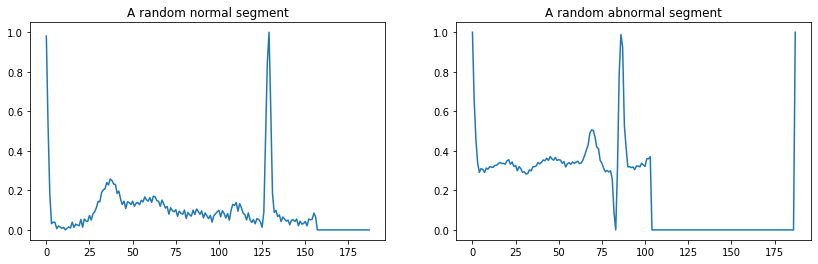

In [141]:
fig,axs = plt.subplots(1,2,figsize=(14,4))

i = np.random.choice(X_normal.shape[0])
axs[0].plot(X_normal[i])
axs[0].set_title('A random normal segment')

i = np.random.choice(X_abnormal.shape[0])
axs[1].plot(X_abnormal[i])
axs[1].set_title('A random abnormal segment');

### Data preprocessing

Please read the code carefully

In [56]:
X = np.concatenate([X_normal, X_abnormal])

In [57]:
X.shape

(14552, 188)

In [58]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [59]:
X.shape

(14552, 188, 1)

In [60]:
y = np.concatenate([np.full(X_normal.shape[0], 0), np.full(X_abnormal.shape[0], 1)])

In [61]:
y.shape

(14552,)

### Train/test split

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [76]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(9749, 188, 1) (9749,)
(4803, 188, 1) (4803,)


### Problem 2. Create at least two 1D convolutional models.

Try playing with the following things:
- use of global max pooling (vs. avg)
- use of an additional dense layer
- number of output channels
- size of the convolutional filters
- pooling size

If you find that you get very high accuracy, try making the validation split in your fit() call much larger.

### Model 1

In [107]:
K.clear_session()

In [108]:
num_output_channels = 16
conv_size = 3
pooling_size = 2
output_size = 48
act_fun = 'relu'
    
model = models.Sequential()
model.add(layers.Conv1D(num_output_channels, conv_size, activation=act_fun, input_shape=(X_train.shape[1],1)))
model.add(layers.MaxPooling1D(pooling_size))
model.add(layers.Conv1D(num_output_channels, conv_size, activation=act_fun))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(output_size, activation=act_fun))
model.add(layers.Dense(1, activation='sigmoid'))

In [109]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 186, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 93, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 91, 16)            784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 48)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4

In [110]:
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])

In [111]:
history = model.fit(X_train, y_train, batch_size=16, epochs=5, validation_split=0.8)

Epoch 1/5
122/122 [==============================] - 3s 18ms/step - loss: 0.5255 - accuracy: 0.7270 - val_loss: 0.4014 - val_accuracy: 0.7224
Epoch 2/5
122/122 [==============================] - 2s 15ms/step - loss: 0.2280 - accuracy: 0.9169 - val_loss: 0.0787 - val_accuracy: 0.9990
Epoch 3/5
122/122 [==============================] - 2s 16ms/step - loss: 0.0283 - accuracy: 0.9990 - val_loss: 0.0082 - val_accuracy: 0.9992
Epoch 4/5
122/122 [==============================] - 2s 13ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 0.0054 - val_accuracy: 0.9991
Epoch 5/5
122/122 [==============================] - 2s 13ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.0052 - val_accuracy: 0.9991


In [112]:
y_pred = model.predict(X_test).flatten().round().astype(int)

In [114]:
print(f'test accuracy: {(y_pred == y_test).mean():.3f}')

test accuracy: 0.999


### Model 2

In [23]:
K.clear_session()

In [24]:
# YOUR CODE HERE: create model

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 186, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 93, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 91, 16)            784       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 48)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4

In [26]:
# YOUR CODE HERE: compile

In [27]:
# YOUR CODE HERE: train the model